In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
sales = pd.read_csv("Global_Superstore2.csv", encoding="latin-1", parse_dates=['Order Date'], index_col='Order Date', dayfirst=True)

In [3]:
sales.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
Order Date,,,,,,,,,,,,,,,,,,,,,
2012-07-31,32298,CA-2012-124891,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
2013-02-05,26341,IN-2013-77878,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2013-10-17,25330,IN-2013-71249,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
2013-01-28,13524,ES-2013-1579342,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
2013-11-05,47221,SG-2013-4320,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Análise Exploratória de Dados

#### Distribuição das Vendas e Lucro

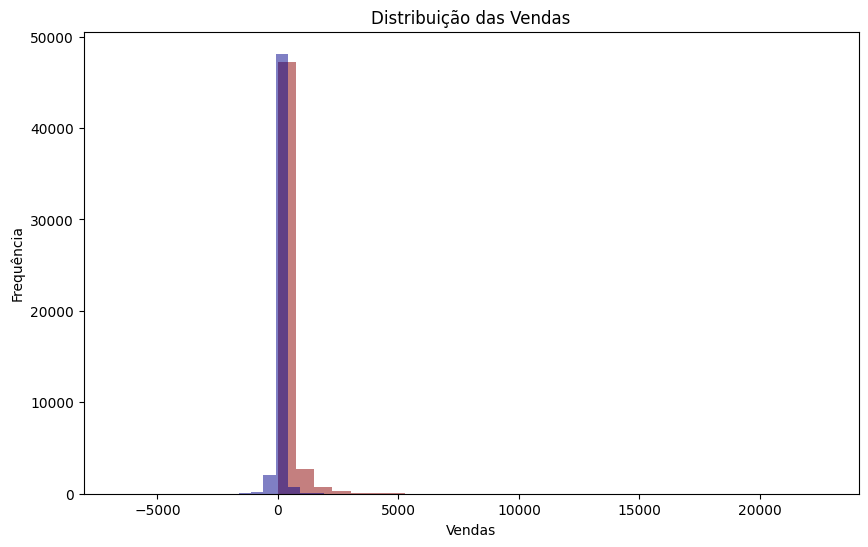

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(sales['Sales'], bins=30, color='darkred', alpha=0.5)
plt.hist(sales['Profit'], bins=30, color='darkblue', alpha=0.5)
plt.title('Distribuição das Vendas')
plt.xlabel('Vendas')
plt.ylabel('Frequência')
plt.show()

#### Vendas ao longo do tempo

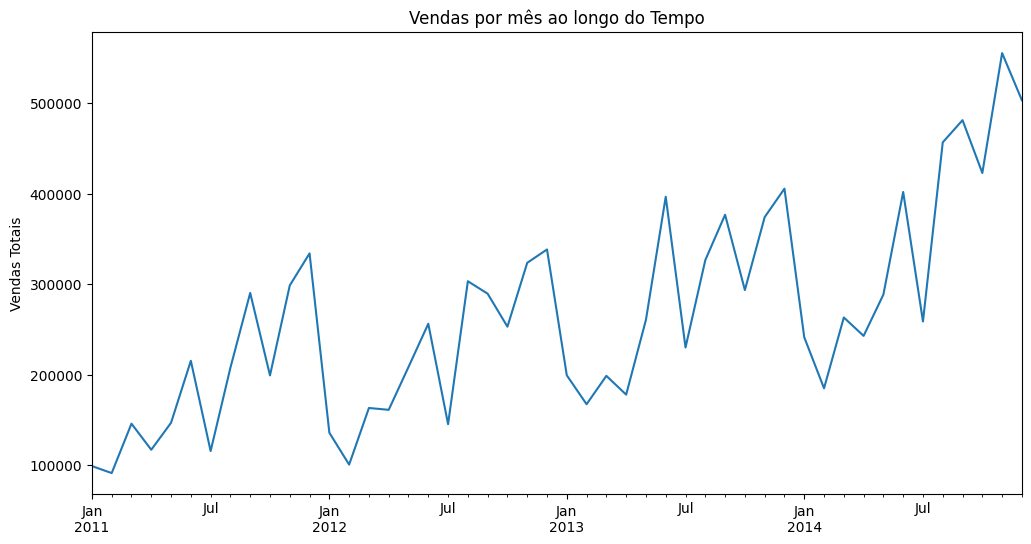

In [5]:
sales_monthly = sales["Sales"].resample("ME").sum()

plt.figure(figsize=(12, 6))
sales_monthly.plot()
plt.title('Vendas por mês ao longo do Tempo')
plt.xlabel('')
plt.ylabel('Vendas Totais')
plt.show()

#### Vendas por Categoria

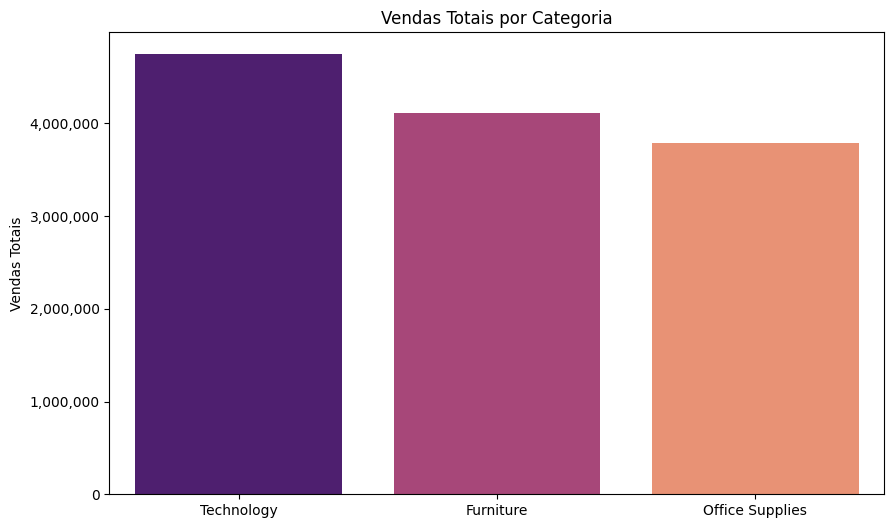

In [6]:
from matplotlib.ticker import FuncFormatter

def formatar_valores(val, _):
    return f'{int(val):,}'

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Sales', data=sales, estimator=sum, errorbar=None, hue='Category', palette="magma", legend=False)
formatter = FuncFormatter(formatar_valores)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Vendas Totais por Categoria')
plt.xlabel('')
plt.ylabel('Vendas Totais')
plt.show()

#### Vendas por Região

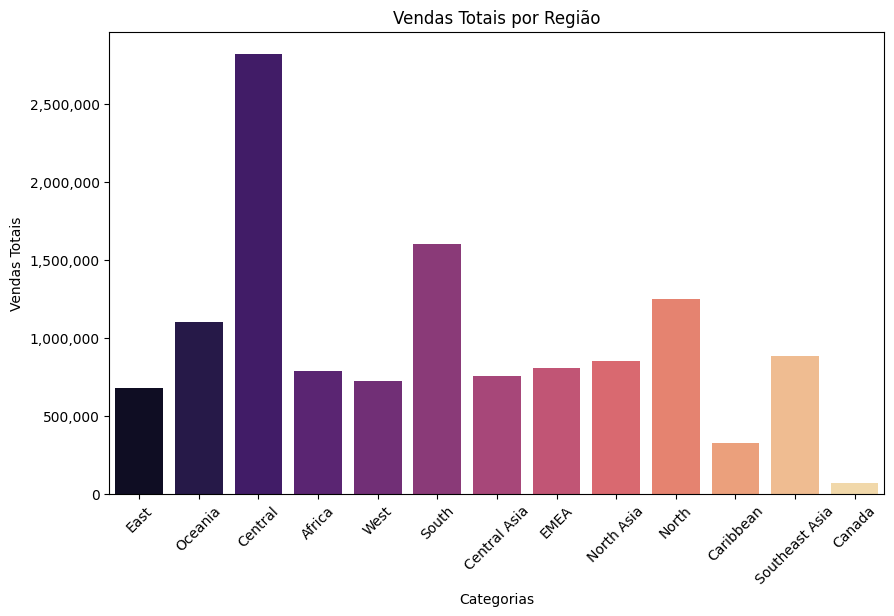

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Sales', data=sales, estimator=sum, errorbar=None, palette="magma", hue='Region', legend=False)
formatter = FuncFormatter(formatar_valores)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.title('Vendas Totais por Região')
plt.xlabel('Categorias')
plt.ylabel('Vendas Totais')
plt.show()

#### Vendas X Lucro

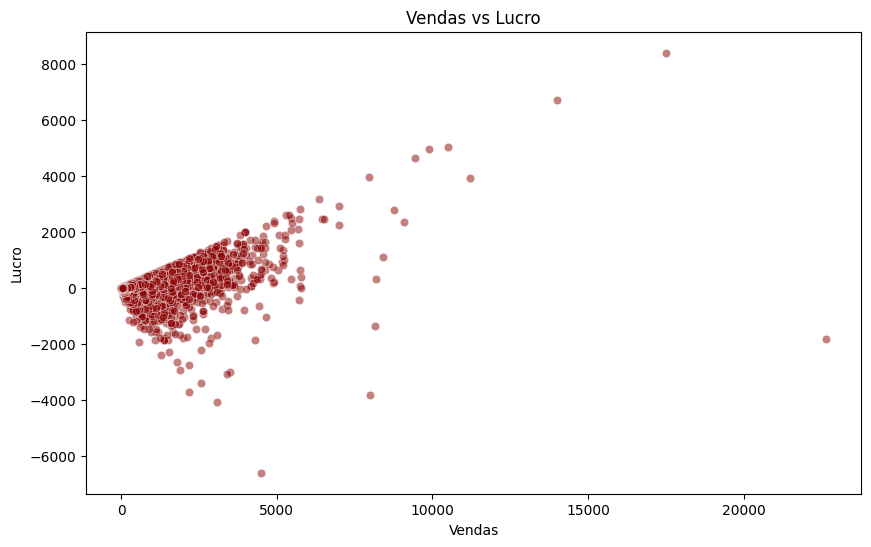

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=sales, alpha=0.5, color='darkred')
plt.title('Vendas vs Lucro')
plt.xlabel('Vendas')
plt.ylabel('Lucro')
plt.show();

#### Lucro por Subcategoria

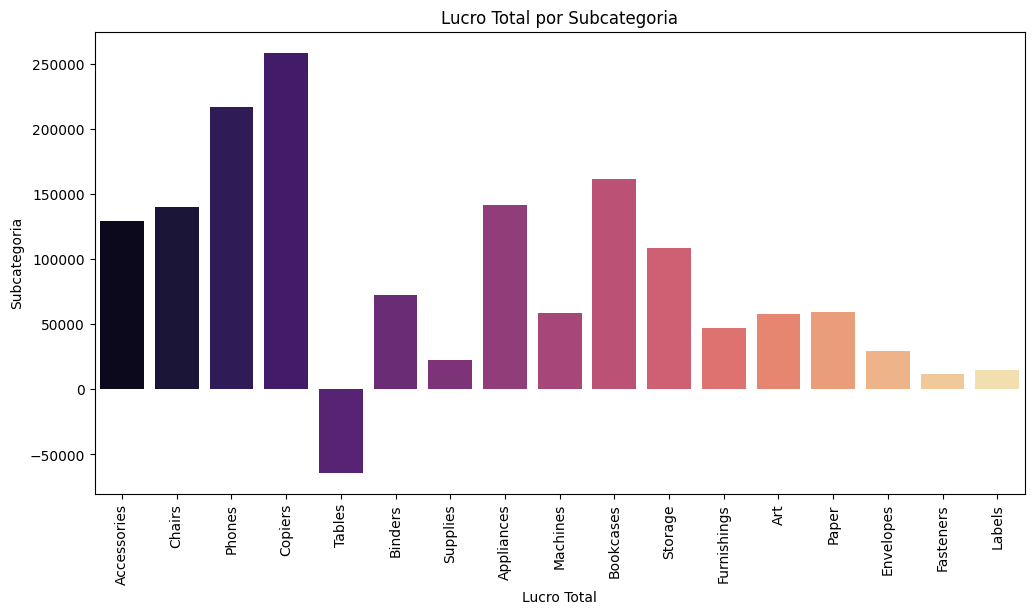

In [9]:
sales_sub = sales.groupby('Sub-Category')['Profit'].sum().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x='Sub-Category', y='Profit', data=sales, estimator=sum, errorbar=None, palette="magma", hue='Sub-Category', legend=False)
plt.xticks(rotation=90)
plt.title('Lucro Total por Subcategoria')
plt.xlabel('Lucro Total')
plt.ylabel('Subcategoria')
plt.show()

### Modelagem com Series Temporais

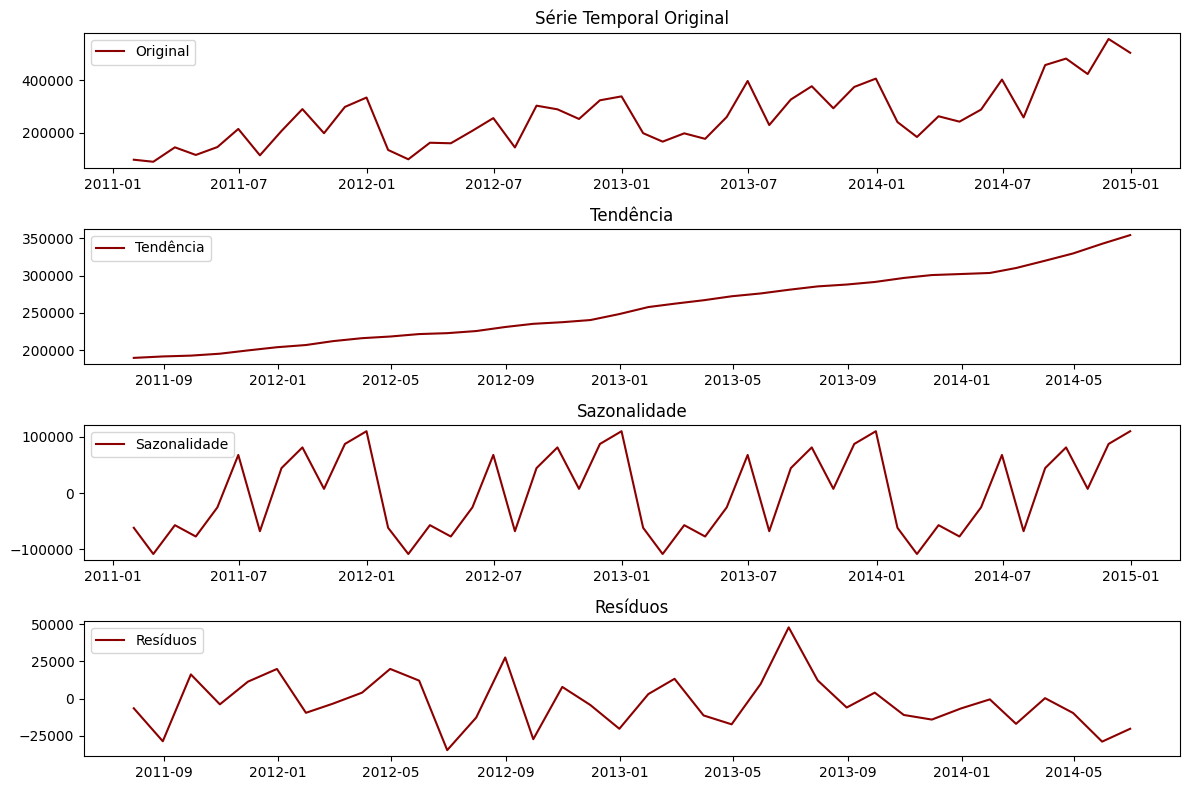

In [19]:
decomposition = seasonal_decompose(sales['Sales'].resample('ME').sum(), model='aditive')

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(sales['Sales'].resample('ME').sum(), label='Original', color='darkred')
plt.legend(loc='upper left')
plt.title('Série Temporal Original')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendência', color='darkred')
plt.legend(loc='upper left')
plt.title('Tendência')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Sazonalidade', color='darkred')
plt.legend(loc='upper left')
plt.title('Sazonalidade')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Resíduos', color='darkred')
plt.legend(loc='upper left')
plt.title('Resíduos')

plt.tight_layout()
plt.show()

#### Separando os dados de treino e teste

In [38]:
y = sales['Sales'].resample('D').sum()

In [39]:
test_size = int(len(y) * 0.2)

In [40]:
train = y[:-test_size]
test = y[-test_size:]

In [41]:
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                 1169
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11691.708
Date:                Sat, 22 Feb 2025   AIC                          23395.416
Time:                        20:35:29   BIC                          23425.794
Sample:                    01-01-2011   HQIC                         23406.874
                         - 03-14-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6657      0.025    -27.048      0.000      -0.714      -0.617
ar.L2         -0.6414      0.030    -21.511      0.000      -0.700      -0.583
ar.L3         -0.5108      0.032    -15.992      0.000      -0.573      -0.448
ar.L4         -0.3815      0.031    -12.449      0.000      -0.442      -0.321
ar.L5         -0.3789      0.024    -15.968      0.000      -0.425      -0.332
sigma2      2.907e+07   3.28e-10   8.85e+16      0.000    2.91e+07    2.91e+07
===================================================================================
Ljung-Box (L1) (Q):                  37.21   Jarque-Bera (JB):               139.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+32. Standard errors may be unstable.
"""

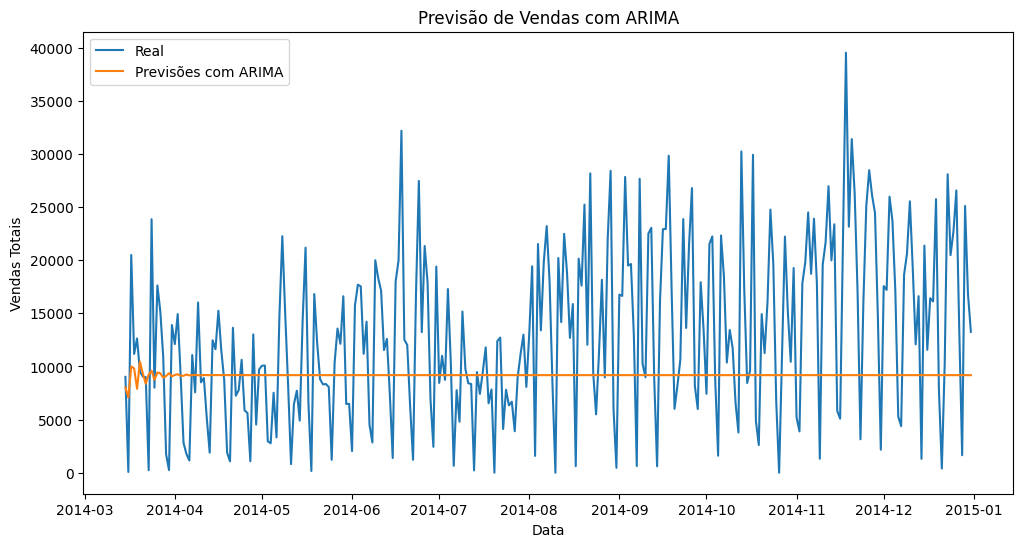

In [42]:
predictions_arima = model_arima_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, predictions_arima, label='Previsões com ARIMA')
plt.title('Previsão de Vendas com ARIMA')
plt.xlabel('Data')
plt.ylabel('Vendas Totais')
plt.legend()
plt.show()

#### Avaliação do Modelo

In [43]:
mse_arima = mean_squared_error(test, predictions_arima)
r2_arima = r2_score(test, predictions_arima)
print(f'ARIMA - Erro Quadrático Médio (MSE): {mse_arima}')
print(f'ARIMA - R²: {r2_arima}')

ARIMA - Erro Quadrático Médio (MSE): 77238067.85567738
ARIMA - R²: -0.22214967265886387


## Conclusão
O modelo parece ser muito ruim para capturar as tendências e prever as vendas